In [0]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import gc

### References
-  Gu, Manchang. (2015). Convolution Neural Networks Embedding K-means. Journal of Information and Computational Science. 12. 6391-6400. 10.12733/jics20107075. 
-  Dundar, Aysegul & Jin, Jonghoon & Culurciello, Eugenio. (2015). Convolutional Clustering for Unsupervised Learning. 
-  Adam Coates, Andrew Y Ng, and Honglak Lee. An analysis of single-layer networks in unsupervised feature learning. In In International Conference on AI and Statistics, 2011.
-  https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/


#### Preprocessing the images from the SVHN dataset

1. Images for test are available in "./train" folder
2. Images for train are available in "./test" folder
3. Each image contains a bounding box of each digit.
4. Preprocessing steps:
    -  Aggregate the bounding boxes of each individual character in a image
    -  Crop the image based on the aggregate dimensions.
    -  The cropped image is resized to 32x32 grey scale image.
    -  ZCA whitening in applied on each image

In [0]:
import h5py

# Function to aggregate the dimensions of the boundary box in a image to one single dimension
def readDigitStruct(filename):
    df = pd.read_csv(filename)
    df.head()

    # http://www.scipy-lectures.org/advanced/image_processing/#basic-manipulations
    # Calculate x1 and y1
    df['x1'] = df['left'] + df['width']
    df['y1'] = df['top'] + df['height']

    # Perform the following aggregations
    aggregate = {'left':'min',
                 'top':'min',
                 'x1':'max',
                 'y1':'max',
                 'label': [lambda x: list(x), 'count']}

    # Apply the aggregation
    df = df.groupby('filename').agg(aggregate).reset_index()
    df.columns = ['filename','x0','y0','x1','y1','labels','label_cnt']
    
    # Calculate the increase in both directions
    df['x_increase'] = ((df['x1'] - df['x0']) * 0.3) / 2.
    df['y_increase'] = ((df['y1'] - df['y0']) * 0.3) / 2.

    # Apply the increase in all four directions
    df['x0'] = (df['x0'] - df['x_increase']).astype('int16')
    df['y0'] = (df['y0'] - df['y_increase']).astype('int16')
    df['x1'] = (df['x1'] + df['x_increase']).astype('int16')
    df['y1'] = (df['y1'] + df['y_increase']).astype('int16')
    
    df['label_cnt'] = df['label_cnt'].astype('uint8')
    
    return df


C:\Users\KUMARS8\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [0]:
import os
import sys

# Returns a DataFrame with the file name and size of all images contained in a folder
def get_image_sizes(folder):   
    # Get all .png images contained in the folder
    image_sizes = [(img,)+plt.imread(folder+'/'+img).shape for img in os.listdir(folder) if img.endswith('.png')]
        
    # Return results as a pandas DataFrame
    return pd.DataFrame(image_sizes,columns = ['filename', 'img_height', 'img_width', 'channels'])

In [0]:
def processDigitStruct(csvFile, imgFolder):
    df = pd.merge(readDigitStruct(csvFile), get_image_sizes(imgFolder), on='filename')
    # Correct bounding boxes not contained by image
    df.loc[df['x0'] < 0, 'x0'] = 0
    df.loc[df['y0'] < 0, 'y0'] = 0
    df.loc[df['x1'] > df['img_width'], 'x1'] = df['img_width']
    df.loc[df['y1'] > df['img_height'], 'y1'] = df['img_height']
        
    df['img_width'] = df['img_width'].astype('int16')
    df['img_height'] = df['img_height'].astype('int16')

    print(df.head()) 
    return df

In [0]:
%%time
# Reading test data from test/digitStruct.csv file
df_test_data = processDigitStruct('./pp_test/digitStruct.csv', 'test')

# Reading train data from train/digitStruct.csv file
df_train_data = processDigitStruct('./pp_train/digitStruct.csv', 'train')

    filename   x0  y0   x1   y1     labels  label_cnt  x_increase  y_increase  \
0      1.png   40   2   64   41        [5]          1        2.85        4.50   
1     10.png   12  15   41   43     [1, 6]          2        3.30        3.15   
2    100.png  119  59  156  104     [6, 1]          2        4.20        5.10   
3   1000.png  204  54  250   91     [2, 7]          2        5.25        4.20   
4  10000.png   30   7   70   35  [1, 4, 3]          3        4.65        3.15   

   img_height  img_width  channels  
0          47         99         3  
1          55         87         3  
2         133        353         3  
3         239        625         3  
4          42        171         3  
    filename   x0  y0   x1   y1      labels  label_cnt  x_increase  \
0      1.png  220  43  444  333      [1, 9]          2       25.95   
1     10.png   21   0   51   37      [1, 6]          2        3.45   
2    100.png   14   0   45   26  [1, 10, 9]          3        3.60   
3   1000.pn

In [0]:
# cv.INTER_AREA, cv.INTER_LINEAR 
df_test_data.shape, df_train_data.shape

((13068, 12), (33402, 12))

In [0]:
import numpy as np
import cv2 as cv

# image size
img_size = (32, 32)

# Read image file and crop it
def yeildConvertToGrey(filename, x0, y0, x1, y1):
    img = cv.imread(filename, 0)
    yield cv.resize(img[y0:y1, x0:x1],img_size)

# Convert all images to cropped greyscale image
def grey_Images(folder, df_img_details):
    greyed_df = pd.DataFrame(columns = ['filename', 'imagedata'])
    for index, row in df_img_details.iterrows():
        filename = folder + '/' + row['filename']
        for dsObj in yeildConvertToGrey(filename, row['x0'], row['y0'], row['x1'], row['y1']):
            greyed_df.loc[len(greyed_df)] = [row['filename'], dsObj]
            
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(greyed_df.loc[i].imagedata.reshape(32,32), cmap='gray')
    # show the plot
    plt.show()
            
    # Return data and labels   
    return greyed_df

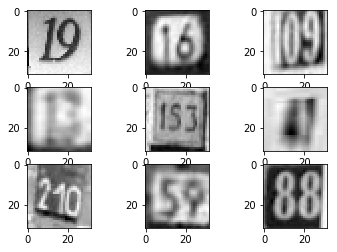

Wall time: 1min 49s


In [0]:
%%time
# Processing training image files
df_train_grey = pd.merge(df_train_data, grey_Images('train', df_train_data), on='filename')
df_train_grey.shape

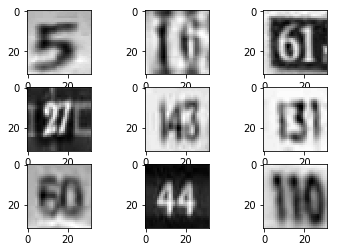

Wall time: 35.3 s


In [0]:
%%time
# Processing test image files
df_test_grey = pd.merge(df_test_data, grey_Images('test', df_test_data), on='filename')
df_train_grey.shape

In [0]:
df_train_grey.head()

,filename,x0,y0,x1,y1,labels,label_cnt,x_increase,y_increase,img_height,img_width,channels,imagedata
0,1.png,220,43,444,333,"[1, 9]",2,25.95,33.45,350,741,3,"[[59, 71, 70, 73, 71, 70, 65, 70, 69, 70, 70, ..."
1,10.png,21,0,51,37,"[1, 6]",2,3.45,4.35,37,74,3,"[[68, 64, 62, 59, 57, 58, 58, 60, 63, 63, 62, ..."
2,100.png,14,0,45,26,"[1, 10, 9]",3,3.60,3.45,27,67,3,"[[229, 231, 236, 231, 220, 212, 212, 214, 212,..."
3,1000.png,15,0,28,21,"[1, 3]",2,1.50,2.70,21,44,3,"[[116, 122, 143, 164, 182, 199, 211, 215, 219,..."
4,10000.png,38,15,94,56,"[1, 5, 3]",3,6.45,4.80,62,137,3,"[[204, 214, 213, 219, 208, 202, 208, 216, 214,..."


In [0]:
df_test_grey.head()

,filename,x0,y0,x1,y1,labels,label_cnt,x_increase,y_increase,img_height,img_width,channels,imagedata
0,1.png,40,2,64,41,[5],1,2.85,4.50,47,99,3,"[[78, 78, 78, 79, 79, 79, 79, 79, 80, 80, 79, ..."
1,10.png,12,15,41,43,"[1, 6]",2,3.30,3.15,55,87,3,"[[196, 199, 207, 209, 195, 178, 166, 158, 149,..."
2,100.png,119,59,156,104,"[6, 1]",2,4.20,5.10,133,353,3,"[[140, 138, 131, 135, 140, 142, 141, 139, 139,..."
3,1000.png,204,54,250,91,"[2, 7]",2,5.25,4.20,239,625,3,"[[44, 47, 50, 50, 49, 50, 50, 49, 46, 44, 44, ..."
4,10000.png,30,7,70,35,"[1, 4, 3]",3,4.65,3.15,42,171,3,"[[214, 214, 214, 212, 210, 209, 210, 210, 210,..."


In [0]:
del df_train_data
del df_test_data
gc.collect()

31116

ZCA_Whitening

In [0]:
from keras.preprocessing.image import ImageDataGenerator

def ZCA(X_train,Y_train, b_size = 10): 
    X_train = X_train.astype('float32')
    
    # enable zca_whitening
    datagen = ImageDataGenerator(zca_whitening=True)
    
    # fit parameters from data
    datagen.fit(X_train)
    index = 0
    
    X = []
    Y = []
    
    # Configure batch size and retrieve one batch of images
    for x_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=b_size):
        X.append(x_batch)
        Y.append(y_batch)
        index = index + b_size
            
        if(index >= len(X_train)):
            break
            
    X = np.array([y for x in X for y in x])
    Y = np.array([y for x in Y for y in x])
    
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X[i].reshape(32,32), cmap='gray')
    # show the plot
    plt.show()
    return X, Y

Using TensorFlow backend.


Enumerate labels

In [0]:
def enumerateLabels(df_label):
    num_of_class = 5
    default_val = 10
    Y = np.full((len(df_label),num_of_class), default_val, dtype=int)
    
    for i, lbls in enumerate(df_label):
        labels = np.array((lbls))
        labels[labels==10] = 0
        # Embed labels into label array
        Y[i,0:labels.shape[0]] = labels
    
    return Y

#### Convert the label list to multilabel format

In [0]:
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html
from sklearn.preprocessing import MultiLabelBinarizer

def labelBinarize(labels):
    print(labels.head())
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    print(labels[0:5])
    return labels

#### Perform ZCA

In [0]:
def processData(df):
    # convert 2D grey data to 3D for input to ZCAs
    X = np.array([np.expand_dims(img, axis=3) for img in df_train_grey['imagedata']])
    
    #Binarize the labels to multilabel format
    Y = labelBinarize(df_train_grey['labels'])

    # ZCA whitening
    X_p,Y_p = ZCA(X,Y)
    
    print("X_p : ", X_p.shape)
    print("Y_p : ", Y_p.shape)
    
    del X
    del Y
    gc.collect()
    
    # imagedata, labels
    return X_p,Y_p

#### Process the cropped images

Processing training(grey) data
0        [1, 9]
1        [1, 6]
2    [1, 10, 9]
3        [1, 3]
4     [1, 5, 3]
Name: labels, dtype: object
[[1 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 1]
 [1 0 1 0 0 0 0 0 0 0]
 [1 0 1 0 1 0 0 0 0 0]]


C:\Users\KUMARS8\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\KUMARS8\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\preprocessing\image.py:645: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


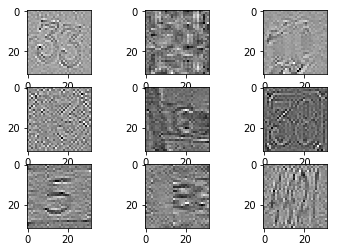

X_p :  (33402, 32, 32, 1)
Y_p :  (33402, 10)
Processing testing(grey) data
0        [1, 9]
1        [1, 6]
2    [1, 10, 9]
3        [1, 3]
4     [1, 5, 3]
Name: labels, dtype: object
[[1 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 1]
 [1 0 1 0 0 0 0 0 0 0]
 [1 0 1 0 1 0 0 0 0 0]]


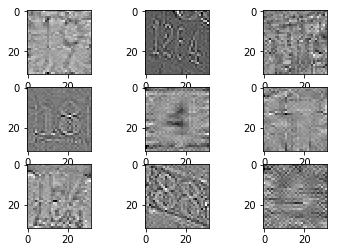

X_p :  (33402, 32, 32, 1)
Y_p :  (33402, 10)
Wall time: 9.38 s


In [0]:
%%time

print("Processing training(grey) data")
X_train, Y_train = processData(df_train_grey)

print("Processing testing(grey) data")
X_test, Y_test = processData(df_test_grey)

del df_train_grey
del df_test_grey
gc.collect()

### Performing feature analysis using K-Means on the the training and test data

1. Cluster size = 90
2. Max iterations = 100

In [0]:
from sklearn.cluster import KMeans

vb=1
# calculate K-Means, default cluster size = 90, max_iter = 100
def GetFeatures_KMeans(df, m_clstr=90, m_iter=100):
    kmeans = KMeans(init='k-means++', n_clusters=m_clstr, max_iter=m_iter, verbose=vb, n_jobs = -2)
    kmeans.fit(df)
    return np.reshape(kmeans.cluster_centers_, (m_clstr,32,32,1))

In [0]:
X_train_vector_64 = np.array(list(map(lambda img: img.flatten(), X_train)))
X_train_vector_64.shape

(33402, 1024)

In [0]:
%%time

clusters = GetFeatures_KMeans(X_train_vector_64,m_iter=10)
clusters.shape

del X_train_vector_64
gc.collect()

Wall time: 1min 10s


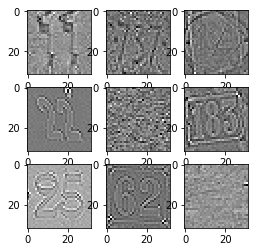

In [0]:
plt.figure(figsize=(4, 4))

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(clusters[i].reshape(32,32), cmap='gray')
# show the plot
plt.show()
    
plt.suptitle('Cluster centers of the patches\n')
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

#### Building the model

In [0]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

In [0]:
num_classes = 10

### Define The Neural Network Model with Single layer

-  Reference : Adam Coates, Andrew Y Ng, and Honglak Lee. An analysis of single-layer networks in unsupervised feature learning. In In International Conference on AI and Statistics, 2011.

Single layer containing
-  Convolutional layer with relu activation { kernel_size = 5; padding = 2, input_shape = (?,32,32,1) }
-  Pooling layer taking the max  { pool_size = 3; strides = 2 }
-  Dropout layer { 0.25 }
-  Flatten layer
-  Softmax classification
-  Output layer

In [0]:
def baseline_model(inputShape=(32,32,1), numClasses=10, num_of_filters = 90):
    # create model
    model = Sequential()
    
    #kernel_size = 5; padding = 2, input_shape = (?,32,32,1)
    model.add(Conv2D(num_of_filters, (5, 5), input_shape=inputShape, padding="same", activation='relu'))
    
    #pool_size = 3; strides = 2
    model.add(MaxPooling2D(pool_size=3, strides=2, padding="same"))
    model.add(Dropout(0.25))
    model.add(Flatten())
             
    #softmax classification
    model.add(Dense(numClasses, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#### epochs=10, batch_size=10

In [0]:
from sklearn.model_selection import train_test_split

# split the training data
XTr, XTe, YTr, YTe = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)
# build the model
model = baseline_model()
# Fit the model
model.fit(XTr, YTr, validation_data=(XTe, YTe), epochs=10, batch_size=10, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 23381 samples, validate on 10021 samples
Epoch 1/10
23381/23381 [==============================] - 37s 2ms/step - loss: 0.4427 - acc: 0.8154 - val_loss: 0.4287 - val_acc: 0.8212
Epoch 2/10
23381/23381 [==============================] - 37s 2ms/step - loss: 0.3984 - acc: 0.8352 - val_loss: 0.3992 - val_acc: 0.8341
Epoch 3/10
23381/23381 [==============================] - 36s 2ms/step - loss: 0.3863 - acc: 0.8417 - val_loss: 0.3846 - val_acc: 0.8418
Epoch 4/10
23381/23381 [==============================] - 36s 2ms/step - loss: 0.3769 - acc: 0.8450 - val_loss: 0.3849 - val_acc: 0.8451
Epoch 5/10
23381/23381 [==============================] - 37s 2ms/step - loss: 0.3707 - acc: 0.8489 - val_loss: 0.3818 - val_acc: 0.8448
Epoch 6/10
23381/23381 [==============================] - 36s 2ms/step - loss: 0.3650 - acc: 0.8513 - val_loss: 0.4008 - val_acc: 0.8419
Epoch 7/10
23381/23381 [==============================] - 37s 2ms/step - loss: 0.3615 - acc: 0.8526 - val_loss: 0.3981 - val_acc

#### Evaluate The Model with k-Fold Cross Validation

In [0]:
%%time

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

seed = 7

estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=2, verbose=0)

kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)

results = cross_val_score(estimator, XTr, YTr, cv=kfold, verbose=1)

print("10-fold cross validation average accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

10-fold cross validation average accuracy: 84.64% (0.21%)
Wall time: 45min 10s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 45.2min finished


#### Define The Neural Network Model with multiple layer
Single layer containing

-  Convolutional layer with relu activation { kernel_size = 5; padding = 2, input_shape = (?,32,32,1) }
-  Pooling layer taking the max { pool_size = 3; strides = 2 }
-  Dropout layer { 0.25 }
-  Convolutional layer with relu activation { kernel_size = 5; padding = 2, input_shape = (?,32,32,1) }
-  Pooling layer taking the max { pool_size = 3; strides = 2 }
-  Convolutional layer with relu activation { kernel_size = 1; padding = 0 }
-  Convolutional layer with relu activation { kernel_size = 1; padding = 0 }
-  Dropout layer { 0.25 }
-  Flatten layer
-  Softmax classification
-  Output layer

In [0]:
def baseline_model_full(inputShape=(32,32,1), numClasses=10, num_of_filters = 90):
    # create model
    model = Sequential()
    
    #kernel_size = 5; padding = 2, input_shape = (?,32,32,1)
    model.add(Conv2D(num_of_filters, (5, 5), input_shape=inputShape, padding="same", activation='relu'))
    
    #pool_size = 3; strides = 2
    model.add(MaxPooling2D(pool_size=3, strides=2, padding="same"))
    model.add(Dropout(0.25))
    #model.add(Flatten())
    
    #kernel_size = 5; padding = 2, input_shape = (?,32,32,1)
    model.add(Conv2D(60, (5, 5), input_shape=inputShape, padding="same", activation='relu'))
    
    #pool_size = 3; strides = 2
    model.add(MaxPooling2D(pool_size=3, strides=2, padding="same"))
    
    #kernel_size = 1; padding = 0, input_shape = (?,32,32,1)
    model.add(Conv2D(70, (1, 1), input_shape=inputShape, padding="valid", activation='relu'))
    
    #kernel_size = 1; padding = 0, input_shape = (?,32,32,1)
    model.add(Conv2D(70, (1, 1), input_shape=inputShape, padding="valid", activation='relu'))
    
    #kernel_size = 3; padding = 1, input_shape = (?,32,32,1)
    model.add(MaxPooling2D(pool_size=3, strides=1, padding="same"))
    
    model.add(Dropout(0.25))    
    model.add(Flatten())
             
    #softmax classification
    model.add(Dense(numClasses, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

##### Running just 5 epochs to reduce runtime

In [0]:
# build the model
model_full = baseline_model_full()
# Fit the model
model_full.fit(XTr, YTr, validation_data=(XTe, YTe), epochs=5, batch_size=100, verbose=1)
# Final evaluation of the model
scores = model_full.evaluate(X_test, Y_test, verbose=2)
print("CNN Error: %.2f%%" % (100-scores[1]*100))


Train on 23381 samples, validate on 10021 samples
Epoch 1/5
23381/23381 [==============================] - 107s 5ms/step - loss: 0.4797 - acc: 0.7990 - val_loss: 0.4374 - val_acc: 0.8137
Epoch 2/5
23381/23381 [==============================] - 109s 5ms/step - loss: 0.3961 - acc: 0.8319 - val_loss: 0.3633 - val_acc: 0.8486
Epoch 3/5
23381/23381 [==============================] - 102s 4ms/step - loss: 0.3448 - acc: 0.8552 - val_loss: 0.3286 - val_acc: 0.8642
Epoch 4/5
23381/23381 [==============================] - 103s 4ms/step - loss: 0.3207 - acc: 0.8659 - val_loss: 0.3041 - val_acc: 0.8744
Epoch 5/5
23381/23381 [==============================] - 104s 4ms/step - loss: 0.3027 - acc: 0.8747 - val_loss: 0.2953 - val_acc: 0.8791
CNN Error: 11.58%
